In [5]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.dates as mdates
from datetime import date, timedelta
import lmfit 
#from seirsplus.models import *
from scipy.integrate import odeint

In [6]:
def get_HR_name(HR_UID):
    conn = sql.connect('../data/hubs.db')
    cursor = conn.cursor()
    
    cursor.execute('SELECT ENGNAME FROM HR WHERE HR_UID = ' + str(HR_UID))
    rows = cursor.fetchall()
    if len(rows) == 0:
        print("No HR with that UID")
        return None
    
    return rows[0][0]

# Use to get data from the Covid19 table. 
#    columns : a string of column names from the Covid19 table, must be separated by ', '. Eg 'dates, cases'
#    HR_UID : a four digit HR ID, as an int or string. Ottawa is 3551
def get_HR_data(columns, HR_UID):
    conn = sql.connect('../data/hubs.db')
    cursor = conn.cursor()

    cursor.execute('SELECT ' + columns + ' FROM Covid19 WHERE HR_UID = ' + str(HR_UID))
    results = pd.DataFrame(cursor.fetchall())
    results.columns = columns.split(', ')
    #print(results[:5])
    cursor.close()
    conn.close()
    
    return results

# Use to get all the health indicators for a health region from the Health_Indicators_ODHF table as a dictionary. 
#    HR_UID : a four digit HR ID, as an int or string. Ottawa is 3551
def get_HR_dict(HR_UID):
    conn = sql.connect('../data/hubs.db')
    cursor = conn.cursor()

    cursor.execute('SELECT * FROM Health_Indicators_ODHF WHERE HR_UID == ' + str(HR_UID))
    tuples = cursor.fetchall()
    if len(tuples) == 0:
        print("No HR with that UID")
        return None

    results = [tuples[0][y] for y in range(len(tuples[0]) - 1)]
    keys = [cursor.description[y][0] for y in range(len(cursor.description) - 1)]

    hr_dict = {}
    for key in zip(keys,results):
        hr_dict[key[0]] = key[1]

    return hr_dict

# Plot the data returned by get_HR_data. 
#    df : a dataframe of the from returned by get_HR_data
#    column : name of column (or columns) to plot. If None, then plots all columns. Should be a string of the same form as in get_HR_data
#    hr_name : name of the HR plotted, as a string. Prints the name of the HR in the title.
def plot_frame(df, column = None, hr_name = None):
    months = mdates.MonthLocator()
    days = mdates.DayLocator()
    years_fmt = mdates.DateFormatter("%Y-%m-%d") # Sets the output format for dates on axis

    # Set up the plot
    fig, ax = plt.subplots(figsize = (19,10))
    dates = df['report_date'].apply(lambda x : np.datetime64(x))
    if column == None:
        column = list(df.columns[1:])
    else:
        column = column.split(', ')
    for col in column:
        ax.scatter(dates, df[col])

    # Set the axis
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(days)

    # Set the axis ranges
    datemin = dates[0]
    datemax = dates[len(dates) - 1]
    ax.set_xlim(datemin, datemax)

    # More axis stuff
    ax.format_xdata = mdates.DateFormatter("%m-%d")
    ax.grid(True)
    fig.autofmt_xdate()
    
    plt.title("Data about " + ", ".join(column) + " by day" + ("" if hr_name == None else ' in ' + hr_name), fontdict = {'fontsize': 20} )
    plt.legend(column, fontsize = 15)

    return fig, ax, plt

# Fitting all parameters to cases and deaths data
## Introduction
In this file, we review the compartmental model improved by being allowed to fit to all parameters as well as having access to cases and deaths data.

We fit to the 'cumulative_cases' and 'cumulative_deaths' columns of the Covid19 table. 

The following is the model that we are fitting:
$$\frac{dS}{dt} = - SI\beta(t) / N$$
$$\frac{dE}{dt} = SI\beta(t) / N - \delta E$$
$$\frac{dI}{dt} = \delta E - \rho \alpha I - \gamma (1 - \alpha) I$$
$$\frac{dD}{dt} = \rho \alpha I$$
$$\frac{dR}{dt} = \gamma (1 - \alpha) I$$
where
- beta $\beta$: rate of transmission.
- delta $\delta$: 1 / incubation period
- rho $\rho$: 1 / time it takes to go from infection to death
- alpha $\alpha$: rate of infected people who die
- gamma $\gamma$: 1 / time it takes to go from infection to recovered

and S,E,I,D,R are the usual Susceptible, Exposed, Infected, Dead, and Recovered compartments.

We model $\beta$ using the reproductive number $R_0$ using the formula $R_0 = \frac{\beta}{\gamma}$. We assume that the region implements social distancing and other virus-suppressing methods, and as such $R_0$ drops at some point during the pandemic, modeled by a logistic curve. That is, we model $R_0$ using the formula
$$R_0(t) = \frac{R_0^s - R_0^e}{1 + \exp(- k (t + x_0))} + R_0^e,$$
where:
- R_0_start $R_0^s$: the value before the logistic switch
- R_0_end $R_0^e$: the value after the logistic switch
- k $k$: how rapidly the switch occurs, higher is faster
- x0 $x_0$: when the switch occurs; the switch is centred around this value

Benefits of modeling $R_0$ in this way is that we can account for the fact that virus prevalence has sharply decreased in the past months; drawbacks of it is that it can only model a single change, so if we take a sharp increase in cases at some point we will have to alter the model. 

Things our model can not account for:
- There are infected people who will never make it into the I compartment because they are not tested. To get around this, we could introduce a 'tested infected' compartment and fit this to the 'cumulative_cases'. To do this, we would need an estimate for proportion of the population that gets tested, and maybe we would have to use some statistical tests to estimate what the true infected population is. 
- On top of the above point, we have to sometimes use some extreme parameters (ie $R_0^s$ set to the max) to fit the cases data because of impact of testing. 

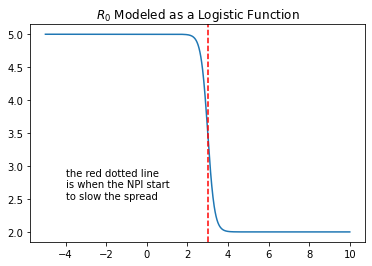

In [33]:
def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start - R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

x_exp = np.linspace(-5,10,1000)
y_exp = [logistic_R_0(x_val, R_0_start = 5, k = 6, x0 = 3, R_0_end = 2) for x_val in x_exp]
plt.plot(x_exp, y_exp)
plt.title("$R_0$ Modeled as a Logistic Function")
plt.axvline(x = 3, color = 'r', linestyle = '--')
plt.text(-4, 2.5, 'the red dotted line\nis when the NPI start\nto slow the spread')
plt.show()

## Data
Let's take a look at the data available to us. We fit the model based on cumulative numbers for cases and deaths (this data comes from the *COVID-19 Canada Open Data Working Group*), and we have access to some general information about the HR's (From the *Open Database of Healthcare Facilities*).

Sources: 
- Covid: https://github.com/ishaberry/Covid19Canada
- ODHF: https://www.statcan.gc.ca/eng/lode/databases/odhf

{'HR_UID': '3551',
 'ambulatory': 63,
 'hospitals': 19,
 'nursing_residential': 150,
 'Perceived_health_good': 0.66,
 'Perceived_health_poor': 0.077,
 'Diabetes': 0.052,
 'Asthma': 0.102,
 'Physical_activity_150mins_adult': 0.664,
 'Physical_activity_60mins_teen': 0.611,
 'Reg_healthcare_provide': 0.882,
 'Influenza_immunization': 0.4,
 'Propo_Population_CA_CMA': 1.0,
 'Ttl_Population_CA_CMA': 934240,
 'Ttl_Rural_population': 64750,
 'Propo_Population_Rural': 0.069,
 'Immigrant_population': 0.236,
 'Dependency_ratio': 0.601,
 'Unemployment_rate': 0.057,
 'Population_rate': 934245,
 'Population_density': 334.8,
 'Cancer_Incidence': 496.1,
 'Birth_low_weight': 0.062,
 'Birth_high_weight': 0.018,
 'Mortality': 581.3}

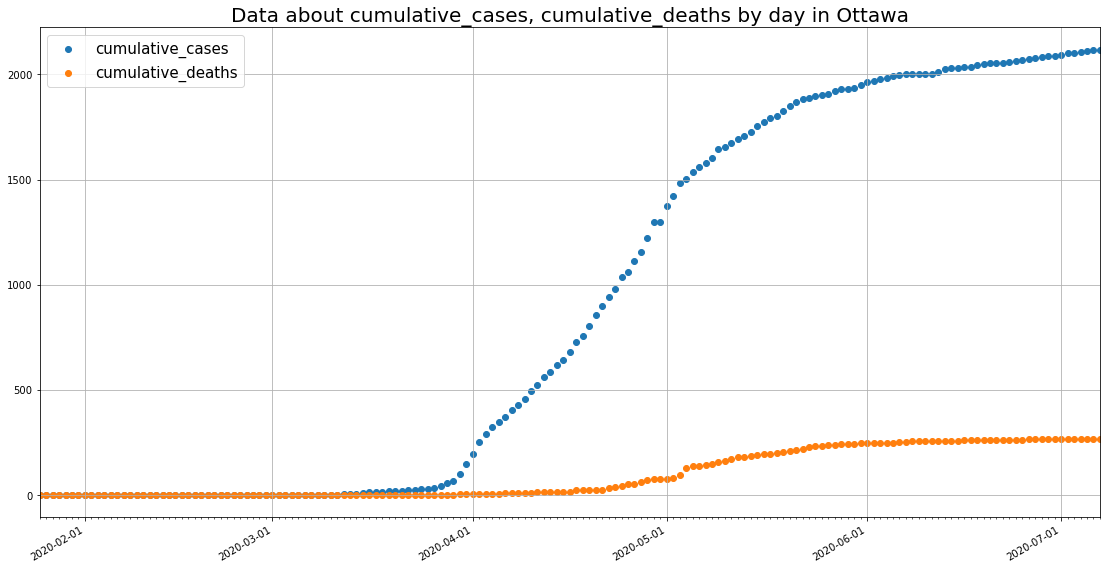

In [8]:
plot_frame(get_HR_data('report_date, cumulative_cases, cumulative_deaths', 3551), hr_name = 'Ottawa')
get_HR_dict(3551)

## The model
We've already shown the differential equations we are modeling in this compartmental SEIDR model. We code these into the `deriv` function, which takes the epidemiological parameters and returns the differentials of each compartment. We also have the `Model` function, which takes all of the parameters and returns the size of the compartments on each day. We also have a `plotting` function. To use the `lmfit` package, we need a `fitter` function, which evaluates the model at each time step and returns the values that we are modeling so that `lmfit` can compute the residuals (by calculating the difference between these values and the input data). 

In [9]:
def deriv(y, t, beta, delta, rho, alpha, gamma, N):
    S, E, I, D, R = y # y wraps up all the compartments
    
    
    dSdt = - S * I * beta(t) / N
    dEdt = S * I * beta(t) / N - delta * E
    dIdt = delta * E - rho * alpha * I - gamma * (1 - alpha) * I
    dDdt = rho * alpha * I
    dRdt = gamma * (1 - alpha) * I
    
    return dSdt, dEdt, dIdt, dDdt, dRdt

def Model(days, N, R_0_start, k, x0, R_0_end, delta, rho, gamma, alpha):
    
    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma
    
    y0 = N - 1.0, 1.0, 0.0, 0.0, 0.0 # Initial population; just one exposed person
    
    t = np.linspace(0, days - 1, int(days))
    ret = odeint(deriv, y0, t, args=(beta, delta, rho, alpha, gamma, N))
    S, E, I, D, R = ret.T
    
    # this is R_0 throughout for plotting
    R_0_over_time = [beta(i) / gamma for i in range(len(t))]
    beta_over_time = [beta(i) for i in range(len(t))]
    
    return t, S, E, I, D, R, R_0_over_time, beta_over_time

# def Model(days, N, model):
#     R_0_start, k, x0, R_0_end = model.best_values.values()
#     return Model(days, N, R_0_start, k, x0, R_0_end)

def plotting(t, S, E, I, D, R, R_0_over_time, beta_over_time, x_ticks = None, x0 = None):
    f,ax = plt.subplots(1,1,figsize=(15,4))
    ax.title.set_text("SEIDR Model")
    
####!=
    if x_ticks is not None:
        months = mdates.MonthLocator()
        days = mdates.DayLocator()
        years_fmt = mdates.DateFormatter("%Y-%m-%d") # Sets the output format for dates on axis

        # Set up the plot
        dates = x_ticks.apply(lambda x : np.datetime64(x))

        # Set the axis
        ax.xaxis.set_major_locator(months)
        ax.xaxis.set_major_formatter(years_fmt)
        ax.xaxis.set_minor_locator(days)

        # Set the axis ranges
        datemin = dates[0]
        datemax = datemin + timedelta(days=len(t) - 1)
        ax.set_xlim(datemin, datemax)

        ax.format_xdata = mdates.DateFormatter("%m-%d")
        #ax.grid(True)
        f.autofmt_xdate()
        
        t = pd.date_range(start = datemin, end = datemax)
####
    def annihilate_small_values(compartment):
        return [compartment[i] if compartment[i] >=1 else 1 for i in range(len(compartment))]

    ax.plot(t, annihilate_small_values(S), 'b', alpha = 0.7, linewidth = 2, label='Susceptible')
    ax.plot(t, annihilate_small_values(E), 'y', alpha = 0.7, linewidth = 2, label='Exposed')
    ax.plot(t, annihilate_small_values(I), 'r', alpha = 0.7, linewidth = 2, label='Infected')
    ax.plot(t, annihilate_small_values(D), 'k', alpha = 0.7, linewidth = 2, label='Dead')
    ax.plot(t, annihilate_small_values(R), 'g', alpha = 0.7, linewidth = 2, label='Recovered')
    ax.set_yscale('log')

    
    ax.grid(b = False, which = 'minor',c='w', lw = 2, ls = '-')
    
    
    
    
    for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)


    #plt.show()

    f = plt.figure(figsize = (15,4))
    # Plot of R_0 over time
    ax1 = f.add_subplot(131)
    ax1.plot(t, R_0_over_time, alpha = 0.7, linewidth=2, label='R_0')
    ax1.title.set_text('Daily R_0 value')
    
    for spine in ('top','right','bottom','left'):
        ax1.spines[spine].set_visible(False)
    
    # Plot of total infected death rate. Calculated as total deaths divided by everyone who's been infected up to that point.
    # Denominator is calculated as delta * sum(E[:t]), because that is all the people added to the I compartment.
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(delta * E[:i]) if sum(delta * E[:i]) > 0 else 0 for i in range(1, len(t))]
    ax2.plot(t, total_CFR, alpha = 0.7, linewidth = 2, label = 'Death Rate among Infected')
    
    ax2.title.set_text("Death Rate %")
    for spine in ('top', 'right', 'bottom', 'left'):
            ax2.spines[spine].set_visible(False)

    # Plot of deaths per day.
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i] - D[i - 1] for i in range(1, len(t))]
    ax3.plot(t, newDs, alpha = 0.7, linewidth=2, label="Daily Deaths")
    ax3.title.set_text("Deaths Per Day")
    for spine in ('top', 'right', 'bottom', 'left'):
            ax3.spines[spine].set_visible(False)
        
    f.autofmt_xdate()
    
    if x0 is not None:
        if x_ticks is not None:
            x0 = datemin + timedelta(days=x0 - 1)
        ax.axvline(x = x0, color = 'r', label = 'x0', linestyle = '--')
        ax1.axvline(x = x0, color = 'r', label = 'x0', linestyle = '--')
        ax2.axvline(x = x0, color = 'r', label = 'x0', linestyle = '--')
        ax3.axvline(x = x0, color = 'r', label = 'x0', linestyle = '--')
        
    ax.legend()
    ax1.legend()
    ax2.legend()
    ax3.legend()
    
    plt.show()
    
def fitter(x, days, N, R_0_start, k, x0, R_0_end, delta, rho, gamma, alpha):
    ret = Model(days, N, R_0_start, k, x0, R_0_end, delta, rho, gamma, alpha)
    new_inf = ret[2] * delta
    cum_cases = [np.sum(new_inf[:i]) for i in range(len(new_inf))]
    
    return np.concatenate([cum_cases, ret[4][x]]) # return the xth value of Deaths, which is 4 in the return list of Model

## Fitting
Now we are ready to do some fitting. We will fit for 7 different HR's and compare their results. We have a helper function that fits the models for us and one that gets data for plotting later.

In [10]:
def fit_SEIDR_model(HR_UID, days_to_ignore = None, param_dict = None, normalized = False):
    
    if normalized == False:
        N, x_dat, cases, deaths, dates = get_some_data(HR_UID)
    else:
        N, x_dat, cases, deaths, dates = get_some_data_normalized(HR_UID)
        
    if days_to_ignore is not None:
        deaths = deaths[:-days_to_ignore]
        cases = cases[:-days_to_ignore]
        
    days = len(deaths)
    data = np.array([cases, deaths]).flatten()
    mod = lmfit.Model(fitter)
    
    if param_dict is not None:
        for kwarg, (init, mini, maxi) in param_dict.items():
            mod.set_param_hint(str(kwarg), value = init, min = mini, max = maxi, vary = True)
    else:
        mod.set_param_hint("R_0_start", value = 5.7, min = 0.1, max = 7, vary = True)
        mod.set_param_hint("k", value = 2, min = .001, max = 5, vary = True)
        mod.set_param_hint("x0", value = 60, min = 10, max = 150, vary = True)
        mod.set_param_hint("R_0_end", value = 1.1, min = 0.01, max = 1.5, vary = True)
        mod.set_param_hint("delta", value = 1 / 5.0, min = 0.0005, max = 0.3, vary = True)
        mod.set_param_hint("rho", value = 1 / 12.0, min = 0.0005, max = 0.3, vary = True)
        mod.set_param_hint("gamma", value = 1 / 19.2, min = 0.0005, max = 0.3, vary = True)
        mod.set_param_hint("alpha", value = 0.1, min = 0.0005, max = 0.3, vary = True)
    
    mod.set_param_hint("days",value = days, vary = False)
    mod.set_param_hint("N", value = N, vary = False)
    
    params = mod.make_params()
    fit_method = 'leastsq'
        
    result = mod.fit(data, params, method = fit_method, x = x_dat)
    return result

def get_some_data(HR_UID):
    hr_dict = get_HR_dict(HR_UID) 
    df = get_HR_data('report_date, cumulative_deaths, cumulative_cases, cases', HR_UID) 
    
    deaths = np.array(df["cumulative_deaths"])
    cases = np.array(df["cumulative_cases"])
    rep_dates = df['report_date']
    days = len(deaths)
    x_dat = np.linspace(0, days - 1, days, dtype=int)
    N = hr_dict['Population_rate']
    
    return N, x_dat, cases, deaths, rep_dates

def get_some_data_normalized(HR_UID):
    hr_dict = get_HR_dict(HR_UID) 
    df = get_HR_data('report_date, cumulative_deaths, cumulative_cases, cases', HR_UID) 
    
    N = hr_dict['Population_rate']
    conv = 1e5 / N
    deaths = np.array(df["cumulative_deaths"]) * conv
    cases = np.array(df["cumulative_cases"]) * conv
    rep_dates = df['report_date']
    days = len(deaths)
    x_dat = np.linspace(0, days - 1, days, dtype=int)
    N = 1e5
    
    return N, x_dat, cases, deaths, rep_dates

def predict_risk(HR_UID, result, model, days_ahead = None):
    if days_ahead is None:
        days_ahead = 0
    days, N, R_0_start, k, x0, R_0_end, delta, rho, gamma, alpha = result.best_values.values()
    
    df = get_HR_data('report_date, cumulative_deaths, cumulative_cases', HR_UID) 
    deaths = np.array(df["cumulative_deaths"])
    cases = np.array(df['cumulative_cases'])

    print("Interested in HR: " + str(HR_UID) + " " + get_HR_name(HR_UID))
    print("According to the model, the total number of cases is " + str(np.floor(sum(delta * model[2][:(days + days_ahead)]))) + ', compared to ' + str(cases[-1]) + ' as reported in the covid data')
    print()
    print('True deaths: ' + str(deaths[-1]))
    print('Predicted deaths: ' + str(model[4][days + days_ahead]))
    if deaths[-1] > model[4][days + days_ahead]:
        print("Thus, health region " + str(HR_UID) + " is a high-risk HR")
    else:
        print("Thus, health region " + str(HR_UID) + " is a low-risk HR")
    

In [16]:
HRs = [3551, 3595, 2406, 4834, 4832, 1204, 4601]
HR_names = ['Ottawa', 'Toronto', 'Montreal', 'Edmonton', 'Calgary', 'Halifax', 'Winnepeg']
# Set initial, min and max values for each of the parameters that are free to vary. Changing these has a big impact on how the model is fit
param_init_min_max = {
    "R_0_start": (3.7, 1, 7),
    "k": (2, 0.001, 5),
    'x0': (60, 10, 150),
    'R_0_end': (0.83, 0.01, 1.5),
    'delta': (1 / 4.7, 1/7.5, 1/4.0), ### Serial Interval; time between onset of symptoms in a primary case and onset of symptoms of a secondary case
    #'delta': (1 / 5.0, 1/6.5, 1/4.0), ### Incubation Period: Time between infection and onset of symptoms
    'rho': (1 / 18.3, 1 / 26.3, 1 / 10.6),
    'gamma': (1 / 18.3, 1 / 26.3, 1 / 3.6),
    #'alpha': (0.06, 0.01, 0.19) ### Case Fatality Rate; deaths among known cases
    'alpha': (0.01, 0.05, 0.3) ### Infection Fatality Rate; estimation of deaths among all infected
}
params_forgiving = {
    "R_0_start": (3.7, 1, 7),
    "k": (2, 0.001, 5),
    'x0': (60, 10, 150),
    'R_0_end': (0.83, 0.01, 1.5),
    'delta': (1 / 4.7, 1/9.5, 1/2.0), ### Serial Interval; time between onset of symptoms in a primary case and onset of symptoms of a secondary case
    #'delta': (1 / 5.0, 1/6.5, 1/4.0), ### Incubation Period: Time between infection and onset of symptoms
    'rho': (1 / 18.3, 1 / 28.3, 1 / 8.6),
    'gamma': (1 / 18.3, 1 / 28.3, 1 / 1.6),
    #'alpha': (0.06, 0.01, 0.19) ### Case Fatality Rate; deaths among known cases
    'alpha': (0.01, 0.0019, 0.2126) ### Infection Fatality Rate; estimation of deaths among all infected
}
old_params = {
    "R_0_start": (5.7, 1, 7),
    "k": (2, 0.001, 5),
    'x0': (60, 10, 150),
    'R_0_end': (0.83, 0.01, 1.5),
    'delta': (1 / 5.0, 0.0005, 0.3), ### Serial Interval; time between onset of symptoms in a primary case and onset of symptoms of a secondary case
    #'delta': (1 / 5.0, 1/6.5, 1/4.0), ### Incubation Period: Time between infection and onset of symptoms
    'rho': (1 / 12.0, 0.0005, 0.3),
    'gamma': (1 / 19.2, 0.0005, 0.3),
    #'alpha': (0.06, 0.01, 0.19) ### Case Fatality Rate; deaths among known cases
    'alpha': (0.1, 0.0005, 0.3) ### Infection Fatality Rate; estimation of deaths among all infected
}
days_ahead = 14 ## Change this value to a positive integer to withhold some of the data from the model. This is how the prediction works.

In [12]:
##### THIS CELL TAKES UP TO 10 MINUTES TO RUN AND OVERWRITES PREVIOUS RESULTS.
res_dict = {}
for hr in HRs:
    res_dict[hr] = fit_SEIDR_model(hr, None, param_init_min_max)
    print(f"Finished with {hr}, which is {get_HR_name(hr)}")

Finished with 3551, which is City of Ottawa Health Unit
Finished with 3595, which is City of Toronto Health Unit
Finished with 2406, which is Région de Montréal
Finished with 4834, which is Edmonton Zone
Finished with 4832, which is Calgary Zone
Finished with 1204, which is Zone 4 - Central
Finished with 4601, which is Winnipeg Regional Health Authority


In [17]:
##### THIS CELL TAKES UP TO 10 MINUTES TO RUN AND OVERWRITES PREVIOUS RESULTS.
res_dict_predict = {}
for hr in HRs:
    res_dict_predict[hr] = fit_SEIDR_model(hr, days_ahead, param_init_min_max)
    print(f"Finished with {hr}, which is {get_HR_name(hr)}")

IndexError: index 151 is out of bounds for axis 0 with size 151

# Prediction process

Suppose $x_1, \dots, x_T$ are the actual cases and deaths data for a particular HR, where $T$ is today. We would like some way to measure whether this HR is at high- or low- risk, as of today.

We have a compartmental model that we can fit to our cases data. Once fitted, we get guesses for the epiparameters and we can extrapolate the model as far forward as we would like. Suppose the model outputs $y_1, \dots, y_N$ for any value of N we choose. 

## Idea: ad-hoc retrospection

Good modelers should always return to their old models and evaluate how well they predicted reality. By restricting the data that we provide to the modeling function, we can make a model as if it was fitted several days ago, and compare how it predicts today should look to how today actually looks.

Method: Given $T$ days of data, fit to the first $T - d$ days, for some $d$. Use the resulting model to predict the number of deaths we'd expect today $y_T$, and compare it to the actual number of deaths $x_T$. 
- If $y_T > x_T$, then there were less deaths than we expected a $d$ days ago. Predict low-risk
- If $y_T < x_T$, then there are more deaths than we expected $d$ days ago. Predict high-risk.

It is important to note that this method only characterizes the *relative* risk level; that is, when we predict low-risk, what we really mean is that the risk is lower in this particular HR than it was before.

{'days': 165, 'N': 720885, 'R_0_start': 4.291547638617474, 'k': 4.512371288163519, 'x0': 69.66724537843004, 'R_0_end': 0.15370149232888147, 'delta': 0.1334668309108472, 'rho': 0.038022813688236186, 'gamma': 0.04358924704967903, 'alpha': 0.0500012497519992}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


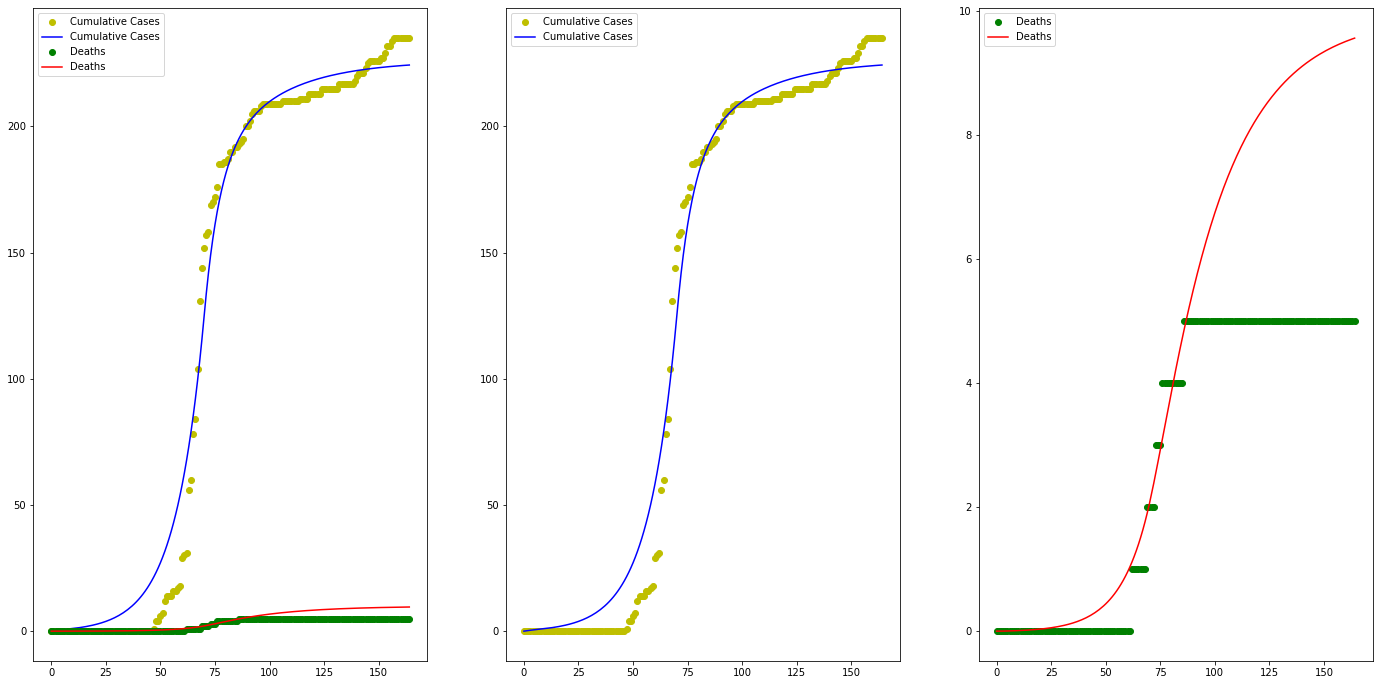

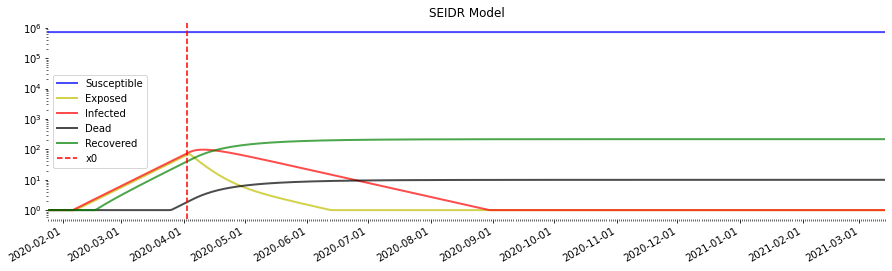

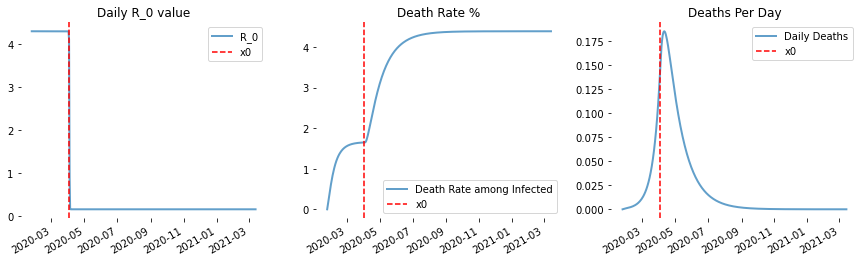

Interested in HR: 4601 Winnipeg Regional Health Authority
According to the model, the total number of cases is 224.0, compared to 235 as reported in the covid data

True deaths: 5
Predicted deaths: 9.577398487771688
Thus, health region 4601 is a low-risk HR


In [29]:
###### BEST EPIDEMIOLOGICAL BOUNDS
hr = HRs[6]
res = res_dict[hr]
N, x_dat, cases, deaths, rep_dates = get_some_data(hr)

print(res.best_values)

###
eva = fitter(x_dat, *res.best_values.values())
half = int(len(eva) / 2)
eva1 = eva[:half]
eva2 = eva[half:]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24,12))

ax1.plot(x_dat, cases, 'oy', x_dat, eva1, '-b', label = 'Cumulative Cases')
ax1.plot(x_dat, deaths, 'og', x_dat, eva2, '-r', label = 'Deaths')
ax1.legend()

ax2.plot(x_dat, cases, 'oy', x_dat, eva1, '-b', label = 'Cumulative Cases')
ax2.legend()

ax3.plot(x_dat, deaths, 'og', x_dat, eva2, '-r', label = 'Deaths')
ax3.legend()

fig.show()

###
days, N, R_0_start, k, x0, R_0_end, delta, rho, gamma, alpha = res.best_values.values()
model_1 = Model(days + 250, N, R_0_start, k, x0, R_0_end, delta, rho, gamma, alpha)
t, S, E, I, D, R, R_0_over_time, beta_over_time = model_1
plotting(*model_1, x_ticks = rep_dates, x0 = x0)

predict_risk(hr, res, model_1, None)

In [26]:
from tabulate import tabulate

parameters = [[get_HR_name(key), key] + list(results.best_values.values())  for key, results in res_dict.items()]
print(tabulate(parameters, headers = ['name','HR_UID'] + list(res_dict[3551].best_values.keys())))

name                                  HR_UID    days        N    R_0_start          k       x0    R_0_end     delta        rho      gamma      alpha
----------------------------------  --------  ------  -------  -----------  ---------  -------  ---------  --------  ---------  ---------  ---------
City of Ottawa Health Unit              3551     165   934245      4.11608  0.144201   83.1749  0.233196   0.133333  0.0382692  0.0578176  0.199766
City of Toronto Health Unit             3595     165  2731570      4.23536  0.0503659  70.2376  0.593788   0.249978  0.0943392  0.0701115  0.0680133
Région de Montréal                      2406     165  1942045      6.85504  0.104966   14.0271  0.987682   0.163464  0.0884585  0.27652    0.233325
Edmonton Zone                           4834     165  1320800      1.33454  0.103669   93.8057  1.41786    0.206082  0.0672516  0.162661   0.181248
Calgary Zone                            4832     165  1551875      3.88037  0.266036   85.691   0.358629   0.

# Other

In [22]:
##### THIS CELL TAKES UP TO 10 MINUTES TO RUN AND OVERWRITES PREVIOUS RESULTS.
res_dict_old_params = {}
for hr in HRs:
    res_dict_old_params[hr] = fit_SEIDR_model(hr, None, old_params)
    print(f"Finished with {hr}, which is {get_HR_name(hr)}")

Finished with 3551, which is City of Ottawa Health Unit
Finished with 3595, which is City of Toronto Health Unit
Finished with 2406, which is Région de Montréal
Finished with 4834, which is Edmonton Zone
Finished with 4832, which is Calgary Zone
Finished with 1204, which is Zone 4 - Central
Finished with 4601, which is Winnipeg Regional Health Authority


{'days': 165, 'N': 934245, 'R_0_start': 5.986961192786389, 'k': 0.166221603889527, 'x0': 78.3804775418139, 'R_0_end': 0.010000000882100355, 'delta': 0.057078586384121305, 'rho': 0.02699555073793461, 'gamma': 0.07145914105517877, 'alpha': 0.2999998068286654}


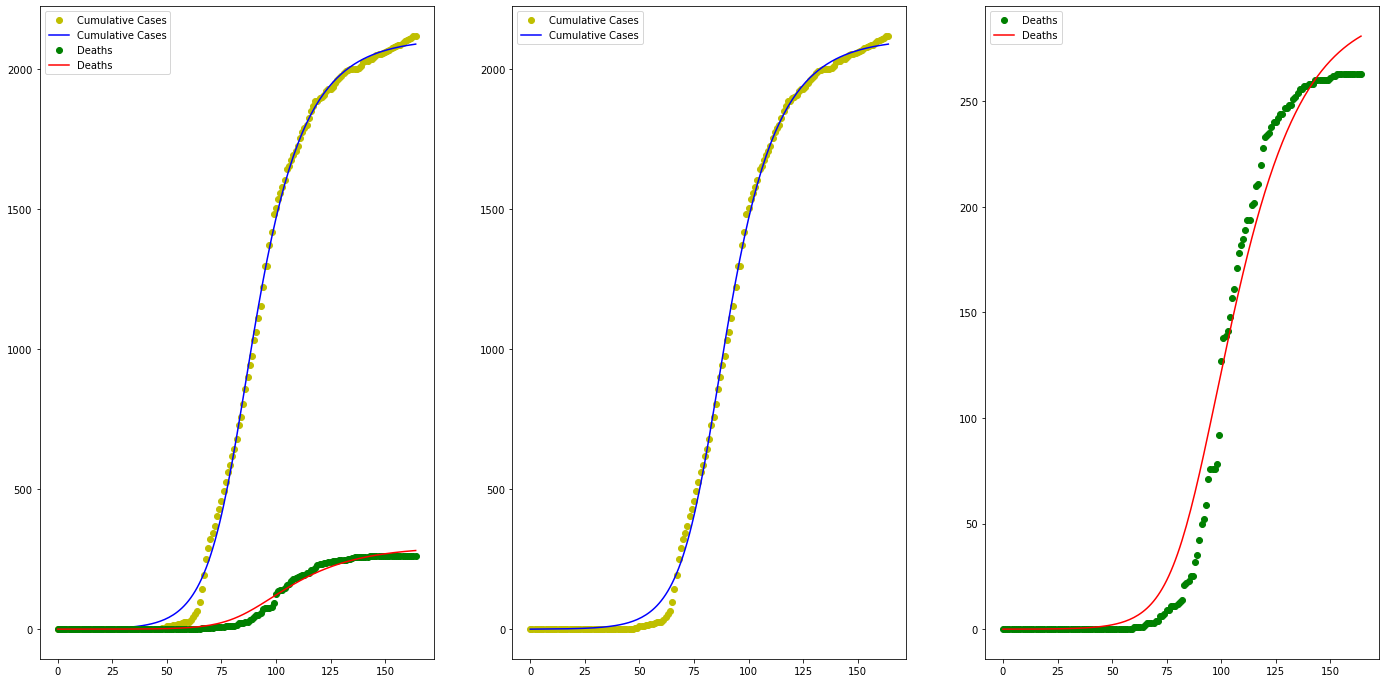

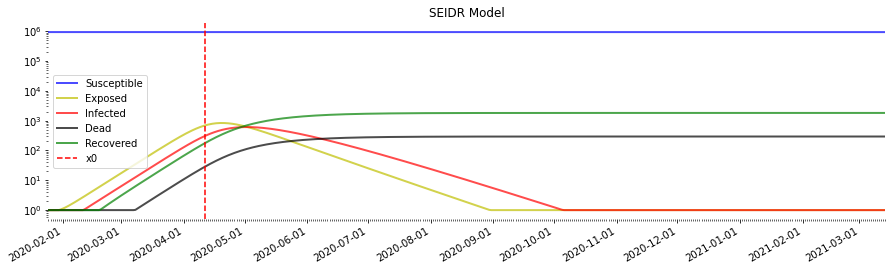

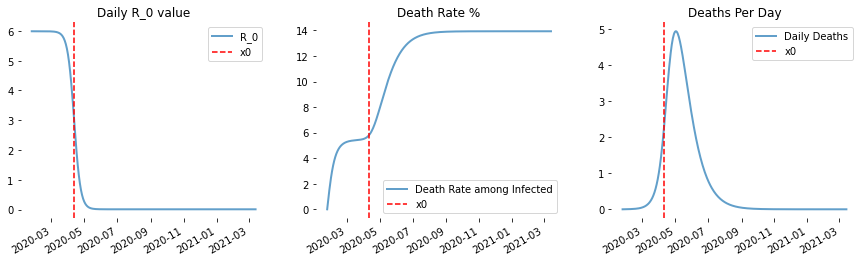

Interested in HR: 3551 City of Ottawa Health Unit
According to the model, the total number of cases is 2090.0, compared to 2118 as reported in the covid data

True deaths: 263
Predicted deaths: 281.43211821907846
Thus, health region 3551 is a low-risk HR


In [28]:
###### OLD BOUNDS THAT TEND TO FIT WELL
hr = HRs[0]
res = res_dict_old_params[hr]
N, x_dat, cases, deaths, rep_dates = get_some_data(hr)

print(res.best_values)

###
eva = fitter(x_dat, *res.best_values.values())
half = int(len(eva) / 2)
eva1 = eva[:half]
eva2 = eva[half:]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24,12))

ax1.plot(x_dat, cases, 'oy', x_dat, eva1, '-b', label = 'Cumulative Cases')
ax1.plot(x_dat, deaths, 'og', x_dat, eva2, '-r', label = 'Deaths')
ax1.legend()

ax2.plot(x_dat, cases, 'oy', x_dat, eva1, '-b', label = 'Cumulative Cases')
ax2.legend()

ax3.plot(x_dat, deaths, 'og', x_dat, eva2, '-r', label = 'Deaths')
ax3.legend()

fig.show()

###
days, N, R_0_start, k, x0, R_0_end, delta, rho, gamma, alpha = res.best_values.values()
model_1 = Model(days + 250, N, R_0_start, k, x0, R_0_end, delta, rho, gamma, alpha)
t, S, E, I, D, R, R_0_over_time, beta_over_time = model_1
plotting(*model_1, x_ticks = rep_dates, x0 = x0)

predict_risk(hr, res, model_1, None)

In [25]:
from tabulate import tabulate

parameters = [[get_HR_name(key), key] + list(results.best_values.values())  for key, results in res_dict_old_params.items()]
print(tabulate(parameters, headers = ['name','HR_UID'] + list(res_dict[3551].best_values.keys())))

name                                  HR_UID    days        N    R_0_start          k       x0    R_0_end      delta        rho      gamma       alpha
----------------------------------  --------  ------  -------  -----------  ---------  -------  ---------  ---------  ---------  ---------  ----------
City of Ottawa Health Unit              3551     165   934245      5.98696  0.166222   78.3805  0.01       0.0570786  0.0269956  0.0714591  0.3
City of Toronto Health Unit             3595     165  2731570      7        0.0563884  58.8862  0.149397   0.0361633  0.0554317  0.278788   0.299995
Région de Montréal                      2406     165  1942045      6.85705  0.0513028  65.8234  0.01       0.12195    0.203772   0.0789709  0.0538594
Edmonton Zone                           4834     165  1320800      6.68615  4.99986    45.2799  0.786625   0.0278104  0.0133366  0.287834   0.3
Calgary Zone                            4832     165  1551875      4.65437  0.227447   87.4207  0.377697   0.3 

# Old code below













In [49]:
##### THIS CELL TAKES UP TO 10 MINUTES TO RUN AND OVERWRITES PREVIOUS RESULTS.
res_dict_forgiving = {}
for hr in HRs:
    res_dict_forgiving[hr] = fit_SEIDR_model(hr, days_ahead, params_forgiving)
    print(f"Finished with {hr}, which is {get_HR_name(hr)}")

Finished with 3551, which is City of Ottawa Health Unit
Finished with 3595, which is City of Toronto Health Unit
Finished with 2406, which is Région de Montréal
Finished with 4834, which is Edmonton Zone
Finished with 4832, which is Calgary Zone
Finished with 1204, which is Zone 4 - Central
Finished with 4601, which is Winnipeg Regional Health Authority


{'days': 165, 'N': 2731570, 'R_0_start': 3.5283230741467126, 'k': 0.05867305105291186, 'x0': 67.11231734255946, 'R_0_end': 0.6018765679963114, 'delta': 0.10526315822661575, 'rho': 0.11627906938222034, 'gamma': 0.20221631764044432, 'alpha': 0.1299121804366461}


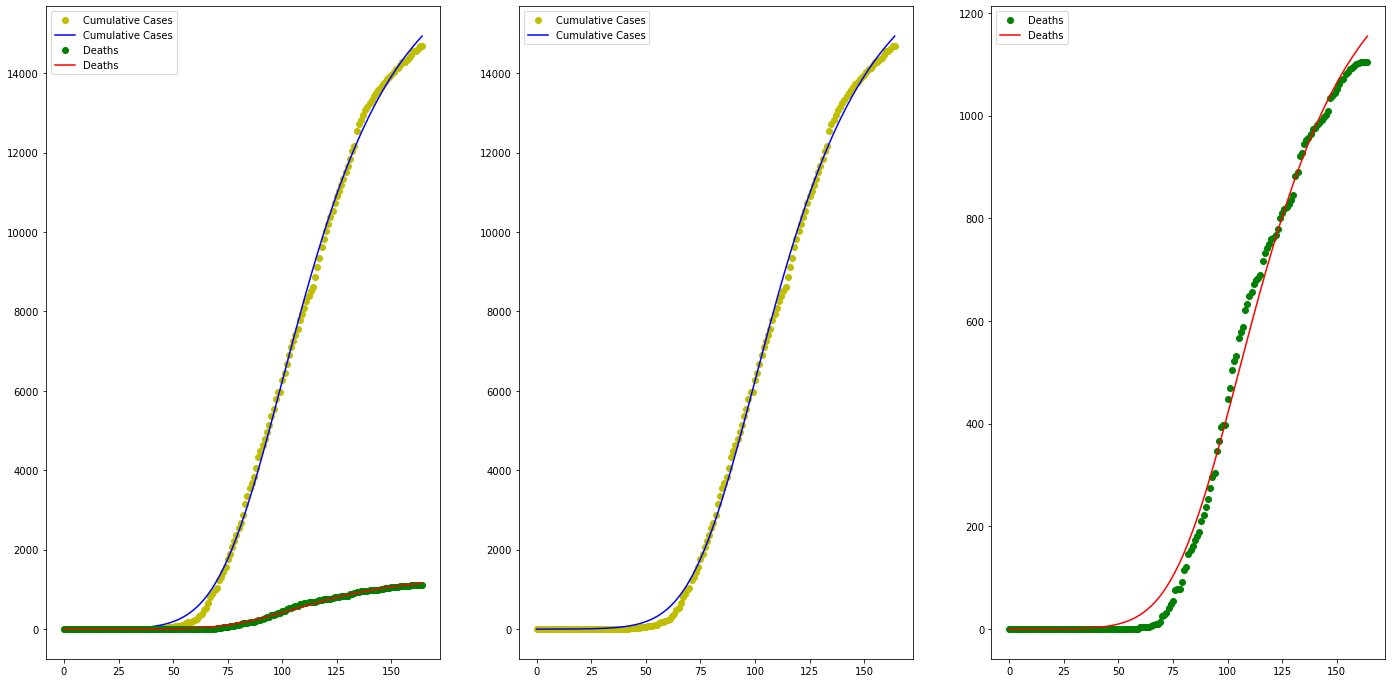

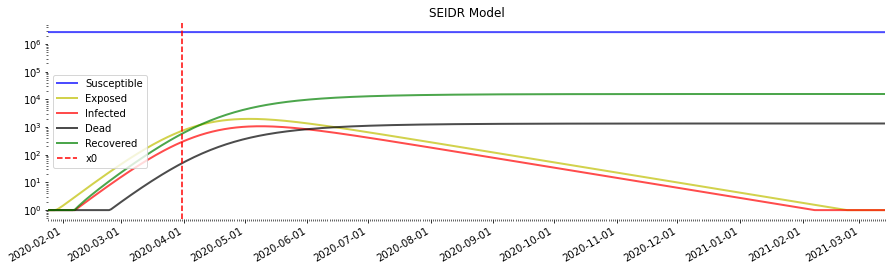

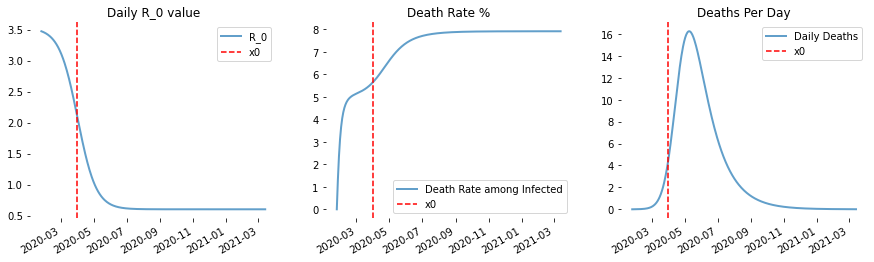

Interested in HR: 3595 City of Toronto Health Unit
According to the model, the total number of cases is 14990.0, compared to 14678 as reported in the covid data

True deaths: 1105
Predicted deaths: 1160.0743652046692
Thus, health region 3595 is a low-risk HR


In [59]:
###### SLIGHTLY LESS RESTRICTIVE EPIDEMILOGICAL BOUNDS
hr = HRs[1]
res = res_dict_forgiving[hr]
N, x_dat, cases, deaths, rep_dates = get_some_data(hr)

print(res.best_values)

###
eva = fitter(x_dat, *res.best_values.values())
half = int(len(eva) / 2)
eva1 = eva[:half]
eva2 = eva[half:]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24,12))

ax1.plot(x_dat, cases, 'oy', x_dat, eva1, '-b', label = 'Cumulative Cases')
ax1.plot(x_dat, deaths, 'og', x_dat, eva2, '-r', label = 'Deaths')
ax1.legend()

ax2.plot(x_dat, cases, 'oy', x_dat, eva1, '-b', label = 'Cumulative Cases')
ax2.legend()

ax3.plot(x_dat, deaths, 'og', x_dat, eva2, '-r', label = 'Deaths')
ax3.legend()

fig.show()

###
days, N, R_0_start, k, x0, R_0_end, delta, rho, gamma, alpha = res.best_values.values()
model_1 = Model(days + 250, N, R_0_start, k, x0, R_0_end, delta, rho, gamma, alpha)
t, S, E, I, D, R, R_0_over_time, beta_over_time = model_1
plotting(*model_1, x_ticks = rep_dates, x0 = x0)

predict_risk(hr, res, model_1, days_ahead)

'days': 165, 'N': 2731570, 'R_0_start': 6.999999994519536, 'k': 0.05638838055611423, 'x0': 58.88621102387808, 'R_0_end': 0.1493973983403247, 'delta': 0.036163309836558175, 'rho': 0.05543172069505489, 'gamma': 0.27878845865610746, 'alpha': 0.2999951240369247

The model seems to perform pretty well for the regions with a decent amount of data; we seem to need about 1000 cases and about 20 deaths to start to be able to fit. Check Winnipeg (`HR[6]`) to see an example of a very bad fit. But the others seem to fit pretty well. 

## Comparing parameters
Here is a table of all the parameters we fit for each HR.

In [1]:
from tabulate import tabulate

parameters = [[get_HR_name(key), key] + list(results.best_values.values())  for key, results in res_dict.items()]
print(tabulate(parameters, headers = ['name','HR_UID'] + list(res_dict[3551].best_values.keys())))

NameError: name 'res_dict' is not defined

## Normalizing by 100k
It was suggested that we normalize all of our values to per 100k residents. This puts everything on the same scale. Here is the code for that. 

In [57]:
HRs = [3551, 3595, 2406, 4834, 4832, 1204, 4601]
HR_names = ['Ottawa', 'Toronto', 'Montreal', 'Edmonton', 'Calgary', 'Halifax', 'Winnepeg']
# Set initial, min and max values for each of the parameters that are free to vary. Changing these has a big impact on how the model is fit
param_init_min_max = {
    "R_0_start": (3.7, 0.1, 7),
    "k": (2, 0.001, 5),
    'x0': (60, 10, 150),
    'R_0_end': (1.1, 0.01, 1.5),
    'delta': (1 / 4.7, 1/7.5, 1/4.0),
    'rho': (1 / 18.3, 1 / 26.3, 1 / 3.6),
    'gamma': (1 / 18.3, 1 / 26.3, 1 / 3.6),
    #'alpha': (0.06, 0.01, 0.19) ### Case Fatality Rate; deaths among known cases
    'alpha': (0.01, 0.0019, 0.0126) ### Infection Fatality Rate; estimation of deaths among all infected
}
days_ahead = None ## Change this value to a positive integer to withhold some of the data from the model. This is how the prediction works.

In [16]:
##### THIS CELL TAKES UP TO 10 MINUTES TO RUN AND OVERWRITES PREVIOUS RESULTS.
res_dict_norm = {}
for hr in HRs:
    res_dict_norm[hr] = fit_SEIDR_model(hr, days_ahead, param_init_min_max, normalized = True)
    print(f"Finished with {hr}, which is {get_HR_name(hr)}')

{'days': 151, 'N': 100000.0, 'R_0_start': 6.8392758704227985, 'k': 4.99109247186601, 'x0': 69.39052704674714, 'R_0_end': 0.010000000027712858, 'delta': 0.06123071717646984, 'rho': 0.001985350445171957, 'gamma': 0.018002071345083984, 'alpha': 0.2999999999889897}
{'days': 151, 'N': 720885, 'R_0_start': 6.84045512840419, 'k': 0.10260260574027828, 'x0': 24.41854284091734, 'R_0_end': 0.7624498758339552, 'delta': 0.16278683076470715, 'rho': 0.15249456881925316, 'gamma': 0.19033964295199768, 'alpha': 0.19450415094753157}


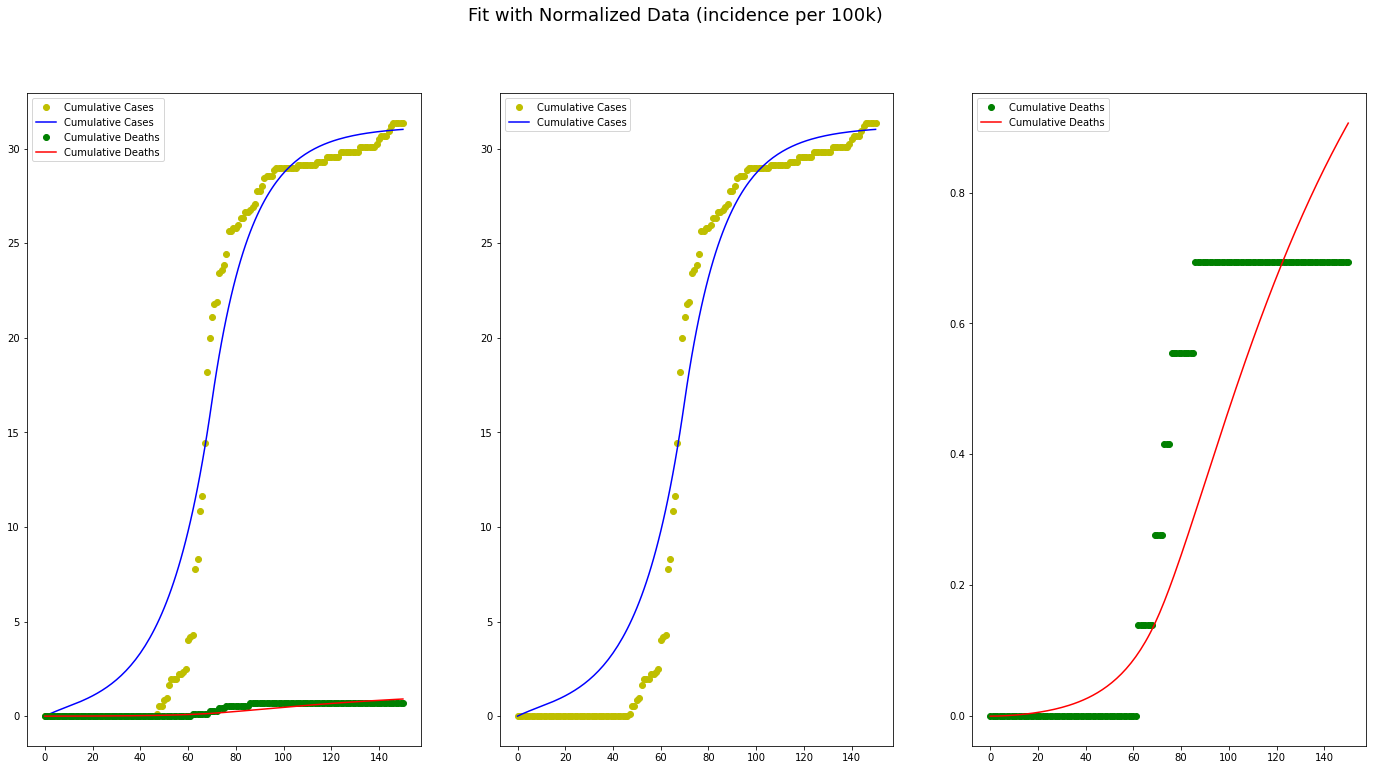

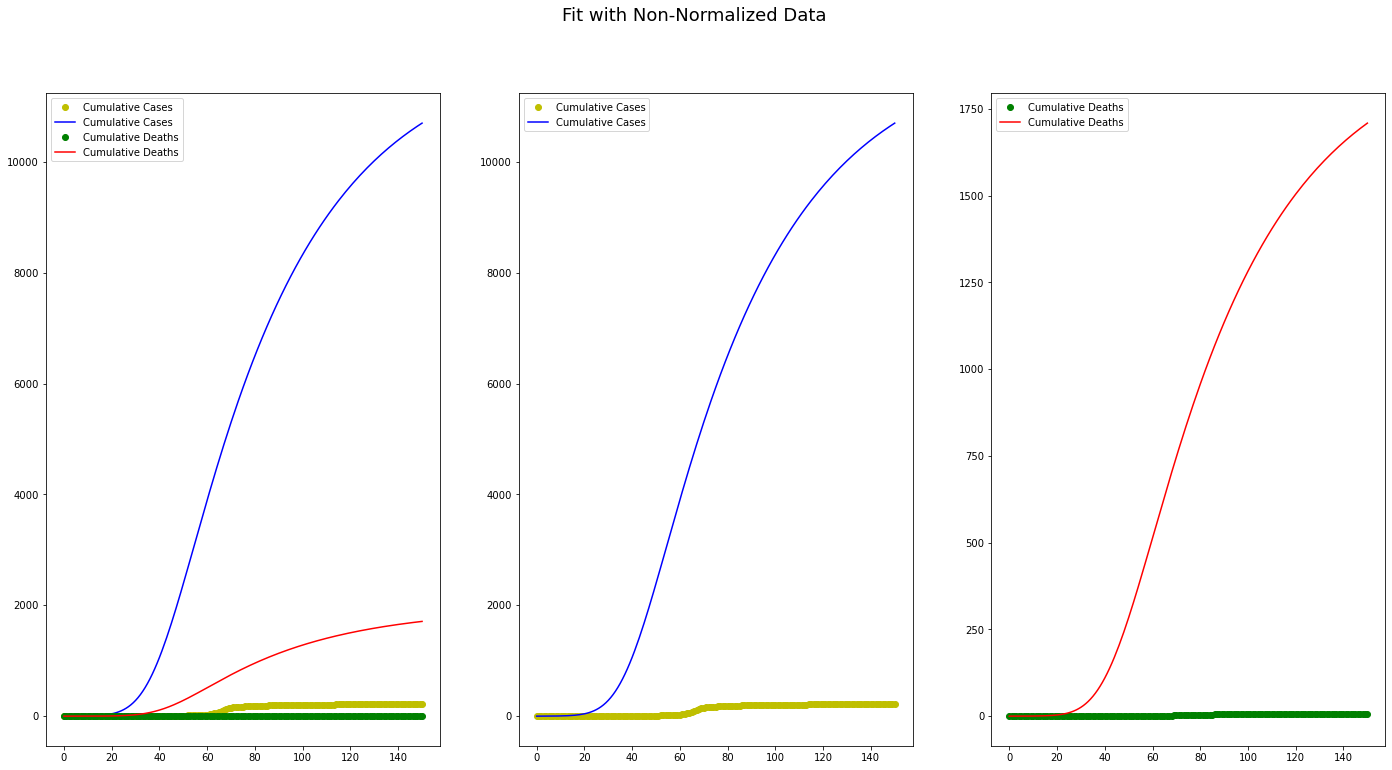

In [82]:
hr = HRs[6]
res = res_dict_norm[hr]
N, x_dat, cases, deaths, rep_dates = get_some_data_normalized(hr)
print(res.best_values)
plot_fit(hr, res, True)


res = res_dict[hr]
N, x_dat, cases, deaths, rep_dates = get_some_data(hr)
print(res.best_values)
plot_fit(hr, res, False)



# days, N, R_0_start, k, x0, R_0_end, delta, rho, gamma, alpha = res.best_values.values()
# model_1 = Model(days + 250, N, R_0_start, k, x0, R_0_end, delta, rho, gamma, alpha)
# t, S, E, I, D, R, R_0_over_time, beta_over_time = model_1
# plotting(*model_1, x_ticks = rep_dates, x0 = x0)
# predict_risk(hr, res, model_1, days_ahead)


In [81]:
def plot_fit(HR_UID, result, normalized = False, title = None):
    if normalized == False:
        N, x_dat, cases, deaths, dates = get_some_data(HR_UID)
    else:
        N, x_dat, cases, deaths, dates = get_some_data_normalized(HR_UID)
        
    eva = fitter(x_dat, *result.best_values.values())
    eva1 = eva[:151]
    eva2 = eva[151:]
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24,12))

    ax1.plot(x_dat, cases, 'oy', x_dat, eva1, '-b', label = 'Cumulative Cases')
    ax1.plot(x_dat, deaths, 'og', x_dat, eva2, '-r', label = 'Cumulative Deaths')
    ax1.legend()

    ax2.plot(x_dat, cases, 'oy', x_dat, eva1, '-b', label = 'Cumulative Cases')
    ax2.legend()

    ax3.plot(x_dat, deaths, 'og', x_dat, eva2, '-r', label = 'Cumulative Deaths')
    ax3.legend()

    if title is None:
        if normalized is True:
            title = "Fit with Normalized Data (incidence per 100k)"
        else:
            title = "Fit with Non-Normalized Data"
    fig.suptitle(title, fontsize = 18)
    fig.show()

Conclusion: Normalizing doesn't appear to make much of a difference. Still, it's probably a good way to standardize results along HR's.

### What's wrong with Winnipeg?
For some reason, We always have a tough time fitting to Winnipeg. For what reason? Is it the model, or are we just consistently getting unlucky results?

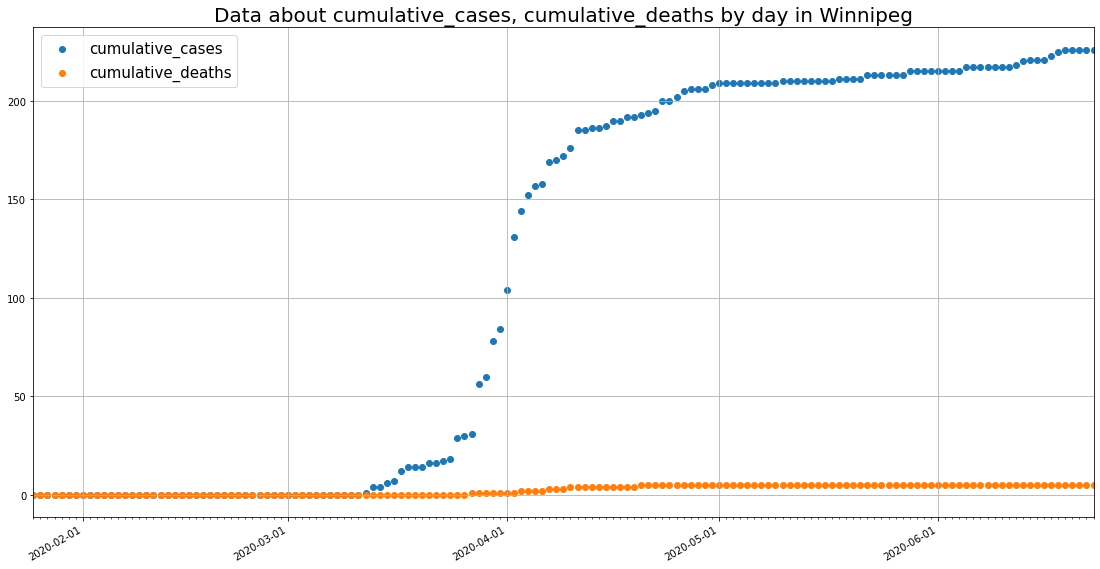

In [87]:
win_hr = 4601
plot_frame(get_HR_data('report_date, cumulative_cases, cumulative_deaths', win_hr), hr_name = "Winnipeg")

param_init_min_max = {
    "R_0_start": (5.7, 0.1, 7),
    "k": (2, 0.001, 5),
    'x0': (60, 10, 150),
    'R_0_end': (1.1, 0.01, 1.5),
    'delta': (1 / 5.0, 0.0005, 0.3),
    'rho': (1 / 12.0, 0.0005, 0.3),
    'gamma': (1 / 19.2, 0.0005, 0.3),
    'alpha': (1 / 10.0, 0.0005, 0.3)
}

In [83]:
winnipeg_res = fit_SEIDR_model(hr, days_ahead, param_init_min_max, normalized = True)

In [89]:
from tabulate import tabulate

parameters = [[get_HR_name(key), key] + list(results.best_values.values())  for key, results in res_dict_norm.items()]
print(tabulate(parameters, headers = ['name','HR_UID'] + list(res_dict_norm[3551].best_values.keys())))

name                                  HR_UID    days       N    R_0_start          k       x0    R_0_end      delta         rho      gamma      alpha
----------------------------------  --------  ------  ------  -----------  ---------  -------  ---------  ---------  ----------  ---------  ---------
City of Ottawa Health Unit              3551     151  100000     6.94937   0.640383   86.4787   0.01      0.0502346  0.0222558   0.0311685  0.239464
City of Toronto Health Unit             3595     151  100000     7         0.296498   79.7284   0.376955  0.0149497  0.0524923   0.26016    0.3
Région de Montréal                      2406     151  100000     5.78646   0.0957044  82.3144   0.01      0.0666306  0.298836    0.0644946  0.0321425
Edmonton Zone                           4834     151  100000     6.97496   4.99483    70.0164   0.876996  0.0826656  0.00174569  0.0149534  0.3
Calgary Zone                            4832     151  100000     0.511783  0.0961228  69.9266   0.76245   0.15953

In [ ]:
Use the epiparameters to set the ranges
evaluation of predictions - how can we evaluate if what we are doing is reasonable?